<a href="https://colab.research.google.com/github/DenisseDB/MachineLearning-BankAnalyses/blob/main/BankSell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

%matplotlib inline

# If you would like to make further imports from Tensorflow, add them here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from imblearn.over_sampling import SMOTE

# Data Balancing
from collections import Counter
from imblearn.over_sampling import KMeansSMOTE

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
# /content/drive/MyDrive/BankData/bank-full.csv
%cd "/content/drive/MyDrive/BankData"

/content/drive/MyDrive/BankData


In [134]:
tf.random.set_seed(42)
np.random.seed(42)

**OBTENER EL DATASET**

Cargar mi dataset y dividirlo para lo que usaremos para el test y el train

In [135]:
df = pd.read_csv("bank-full.csv", delimiter=";")

*Limpiar los datos*

Seleccionar columnas que usaremos para el modelo


In [136]:
columnas = ['age', 'marital', 'education', 'default', 'loan', 'duration', 'y']
df_columnas_seleccionadas = df[columnas]

In [137]:
df_columnas_seleccionadas = df_columnas_seleccionadas[df_columnas_seleccionadas['education'] != 'unknown']
df_columnas_seleccionadas.reset_index(drop=True, inplace=True)
df_columnas_seleccionadas.shape

(43354, 7)

**SEPARACIÓN DEL SET DE PRUEBA Y DEL SET DE TRAINING**

Ya que lo limpiamos, ahora si dividimos el data set para tener el conjunto que sera entrenado y el conjunto que sera para pruebas (train_data y test_data)

In [138]:
train_data = df_columnas_seleccionadas.iloc[:34000]
test_data = df_columnas_seleccionadas.iloc[34000:]

Como queremos estudiar si contrataran o no la tarjeta, y ese dato viene en la columna Y, debemos quitar esa información de nuestros fragmentos de datos

In [139]:
test_labels_target = test_data["y"]
test_data = test_data.drop(columns=["y"])
train_labels_target = train_data["y"]
train_data = train_data.drop(columns=["y"])

**PREPROCESADO DEL TARGET**
*Label Encoder*

Como el modelo solo acepta números, debemos pasar mi target a binario, para eso usaremos Label encoder, ya que:

*   Solo tenemos dos categorias (yes / no)
*   Al tener solo dos categorias, no hay problema confusión de orde
*   Usa menos memoria



In [140]:
enc = LabelEncoder()
train_labels_target = enc.fit_transform(train_labels_target)
test_labels_target = enc.transform(test_labels_target)

**PREPROCESADO DE FEATURES**

Usamos OneHotEncoder ya que tenemos mas de dos categorias, nos guiamos con "Titanic Solution One-Hot-Encode All The Things"

In [141]:
# Apply one-hot encoder to each column with categorical data
object_cols = train_data.select_dtypes(include='object').columns
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_encoder.fit(train_data[object_cols])
OH_cols_train = pd.DataFrame(OH_encoder.transform(train_data[object_cols]))
joblib.dump(OH_encoder, '/content/drive/MyDrive/BankData/onehotencoder.pkl')
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_data[object_cols]))

OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()

# One-hot encoding removed index; put it back
OH_cols_train.index = train_data.index
OH_cols_test.index = test_data.index

# Add one-hot encoded columns to numerical features (age - duration)
numeric_columns = train_data.drop(columns=object_cols).columns
numeric_train = train_data[numeric_columns]
numeric_test = test_data[numeric_columns]

train_data = pd.concat([OH_cols_train, numeric_train], axis=1)
test_data = pd.concat([OH_cols_test, numeric_test], axis=1)

**Construir el modelo**

Dropout nos ayuda a evitar que el modelo se aprenda de memoria los datos de la clase mayoritaria

In [142]:
def get_model_simple(input_shape):
    model  =  Sequential([
                    Flatten(input_shape=input_shape),
                    # las capas del modelo
                    Dense(256, activation='relu'),
                    Dropout(0.3),
                    Dense(256, activation='relu'),
                    Dropout(0.4),
                    Dense(128, activation='relu'),
                    Dropout(0.4),
                    Dense(64, activation='relu'),
                    Dropout(0.3),
                    # solo necesitamos una neurona de salida cuando trabajamos con binario
                    Dense(1, activation='sigmoid')
    ])
    return model

Learning Rate = que tan rqapido cambian los pesos, entre mas cercano a 1, mas rapido es el cambio

In [143]:
#0.001 de acuerdo al paper
optimizer = Adam(learning_rate=0.0005)

In [144]:
# pasamos los hiperparametros y configurar la red
def compile_model_simple(model):
    # loss = diferencia entre las predicciones de un modelo
    model.compile(optimizer= optimizer, loss = "binary_crossentropy", metrics=['accuracy',
                                                                            tf.keras.metrics.Precision(name="precision"),
                                                                            tf.keras.metrics.Recall(name="recall"),
                                                                           ])



* train_data son los datos que usaremos para el entrenamiento
* train_labels_target para que voy a entrenar mis train_data
* epochs las epocas para saber cuantas veces le voy a dar la vuelta



In [145]:
def train_model_simple(model, train_data, train_labels_target):
    history = model.fit(train_data, train_labels_target, epochs=250, batch_size=64, class_weight=class_weights, validation_data=(test_data, test_labels_target))
    return history

**BALANCEO DE DATOS USANDO K-MEANS SMOTE**

In [146]:
# print(f"The number of classes before fit: {Counter(train_labels_target)}")
# kms = KMeansSMOTE(random_state=42)
# train_data, train_labels_target = kms.fit_resample(train_data, train_labels_target)
# print(f"The number of classes after fit: {Counter(train_labels_target)}")

In [147]:
# print(f"The number of classes before fit: {Counter(train_labels_target)}")
# sm = SMOTE(random_state=2)
# train_data, train_labels_target = sm.fit_resample(train_data, train_labels_target)
# print(f"The number of classes after fit: {Counter(train_labels_target)}")

*Después de dos intentos fallidos, el oversample no estaba siendo la mejor opcion, por lo tanto, haremos oversample y undersample*

In [148]:
pipline = Pipeline([
    ('oversample', SMOTE(sampling_strategy={1: 15000}, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 12000, 1: 15000}, random_state=42))
])

train_data, train_labels_target = pipline.fit_resample(train_data, train_labels_target)
print(f"The number of classes after fit: {Counter(train_labels_target)}")

The number of classes after fit: Counter({np.int64(1): 15000, np.int64(0): 12000})


Evitemos que el modelo ignore a la clase minoritaria, decirle al modelo, cuando le va a doler equivocarse


In [149]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels_target), y=train_labels_target)
class_weights = dict(enumerate(weights))

* Obtenemos el modelo, entre mas parametros es mas poderoso el modelo, sin embargo, será mas pesado
* Con summary vemos el modelo completo para despues compilarlo
* Hacemos el entrenamiento

In [150]:
model_nn = get_model_simple(input_shape=train_data.shape[1:])
model_nn.summary()
compile_model_simple(model_nn)
history_nn = train_model_simple(model_nn, train_data, train_labels_target)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,337 (431.00 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5969 - loss: 4.3254 - precision: 0.6108 - recall: 0.7522 - val_accuracy: 0.7297 - val_loss: 0.5444 - val_precision: 0.6598 - val_recall: 0.1534
Epoch 2/250
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6956 - loss: 0.6843 - precision: 0.7182 - recall: 0.7397 - val_accuracy: 0.7333 - val_loss: 0.5474 - val_precision: 0.6372 - val_recall: 0.2007
Epoch 3/250
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7430 - loss: 0.5515 - precision: 0.7801 - recall: 0.7449 - val_accuracy: 0.7289 - val_loss: 0.5408 - val_precision: 0.6678 - val_recall: 0.1421
Epoch 4/250
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7608 - loss: 0.5178 - precision: 0.8108 - recall: 0.7397 - val_accuracy: 0.7298 - val_loss: 0.5356 - val_precision: 0.6564 - val_recall: 0.1567
Epoch 5/250
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7718 - loss: 0.5060 - precision: 0.8249 - recall: 0.7453 - val_accuracy: 0.7359 - val_lo

**MATRIZ DE CONFUSION**


Threshold a 0.3 para no ser tan duros con los casos de "yes" si no, darle mas oportunidad al modelo de darnos resultados cuando no esta convencido.

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


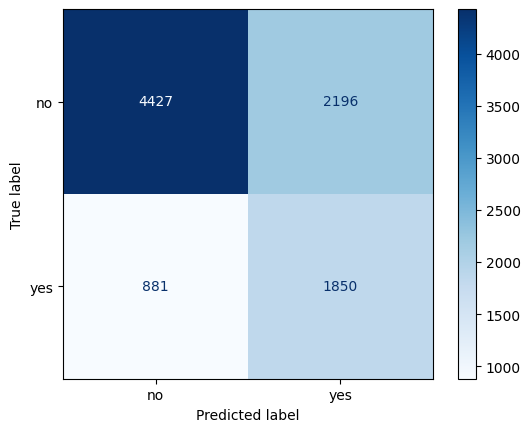

In [151]:
predictions_probabilities = model_nn.predict(test_data)
predictions = (predictions_probabilities > 0.3).astype(int)
predictions = predictions.flatten()

cm = confusion_matrix(test_labels_target, predictions)
labels = enc.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

De la prediccion:
Precision: Cuantos eran realmente positivos
Racall: De los TP, cuantos detecto el modelo
F1 Score: Media entre Precision y Recall (para datos desbalanceados)
Support: Cuantos yes y no había

Resumen: conocer si el modelo que tiene datos desbalanceados, realmente esta detectando de manera correcta la clase menos frecuente (yes)

In [152]:
print(classification_report(test_labels_target, predictions, target_names=labels))

              precision    recall  f1-score   support

          no       0.83      0.67      0.74      6623
         yes       0.46      0.68      0.55      2731

    accuracy                           0.67      9354
   macro avg       0.65      0.67      0.64      9354
weighted avg       0.72      0.67      0.68      9354



**GUARDAR MODELO**

In [153]:
model_nn.save("banksell.keras")